# Analyse fixation in local search trials

In [1]:
import numpy as np
import pandas as pd
    
from os import mkdir, walk, getcwd
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d
from scipy import stats as sts
from scipy.optimize import curve_fit
from scipy.stats import circmean as circmean

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import rcParams
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

# import basic data processing function
from flyVR.utilities.loadSingleTrial import loadSingleVRLogfile
from flyVR.utilities.loadObjectCoords import loadObjectCoordIdentities

from flyVR.flyVRstripetracking.flyVRstripetracking_fourConditions_oneFlyAnalysis import processTrackingTrial

from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec, RayleighTest

# import custom plotting functions
from plottingUtilities.basicPlotting import myAxisTheme, _myAccentList
from plottingUtilities.objectInteractionPlots import plotHeadingComparison, plot2DHeadingComparison,plotWalkingVelocityDistr

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [226]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)

print('\n Analysing the following {} log files:\n'.format(len(FODataFiles)))
for FOfile in FODataFiles:
    print(FOfile) 


 Analysing the following 20 log files:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_9d_180909170029.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_9d_180909172526.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f03_26h_9d_180909184521.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f04_24h_10d_180910163546.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_6-9d_180910170356.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f06_26h_6-9d_180910184052.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f07_24h_7-10d_180911161226.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f08_24h_7-10d_180911163951.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f09_25h_7-10d_180911175603.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_G

In [227]:
dataDir = sep.join(expDir.split(sep)[0:-2]) + sep

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

### Compose mutli-fly data into dataframe

In [228]:
# generate fly color map
numFlies = len(FODataFiles)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [229]:
genotype = dataDir.split(sep)[-5][:-2]
protocol = dataDir.split(sep)[-2]
print(genotype)
print(protocol)

hexGridSize = int(dataDir.split(sep)[-4][:2])*10
print(hexGridSize)

Gr64f_x_10xChrimsonR
visLM
120


In [230]:
keylist = ['gamma','gammaFull','LMdist','headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','sceneName','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Run single trial analysis on each file in folder .....................................................
for fileToAnalyse in FODataFiles:
    print('\n Analysing the following log file:\n')
    print(fileToAnalyse)

    flyID = fileToAnalyse.split('_')[-4]
    starvation = fileToAnalyse.split('_')[-3]

    trial = FODataFiles.index(fileToAnalyse) + 1

    print('Loading saved *.npy file.')
    FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

    # Split into visible object trials and invisible object trials
    if 'train' in fileToAnalyse:
        trialtype = 'train'
        rZones = 'on'
    elif 'pre' in fileToAnalyse:
        trialtype = 'pre'
        rZones = 'off'
    else:
        trialtype = 'post'
        rZones = 'off'

    vTrans = np.copy(FODatLoad['transVelo'])
    moving = vTrans >= vTransTH
    LMdist = np.hypot(FODatLoad['xPosInMiniarena'], FODatLoad['yPosInMiniarena'])

    FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
    FODatLoad_df.insert(0, 'flyID', flyID)
    FODatLoad_df.insert(1, 'trial', trial)
    FODatLoad_df.insert(2, 'trialtype', trialtype)
    FODatLoad_df.insert(3, 'reinforcement', rZones)
    FODatLoad_df.insert(4, 'sceneName', protocol)
    FODatLoad_df.insert(5, 'moving', moving)
    FODatLoad_df.insert(6, 'LMdist', LMdist)

    FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_9d_180909170029.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_9d_180909172526.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f03_26h_9d_180909184521.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f04_24h_10d_180910163546.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_6-9d_180910170356.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f06_26h_6-9d_180910184052.txt
Loading saved *.npy file.

 Analysing the f

In [231]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))
%matplotlib inline

FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,sceneName,moving,gamma,gammaFull,LMdist,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,-0.000004,1.087098,0.000000,17.761374,60.622000,NaN,35.000000,NaN,0.0
1,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.054353,1.304424,0.050002,8.490858,61.499344,NaN,34.862218,NaN,0.0
2,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.119576,1.413144,0.100003,7.494538,61.923075,NaN,34.835742,NaN,0.0
3,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.190236,1.304417,0.150005,4.026785,62.289100,NaN,34.755400,NaN,0.0
4,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.255459,1.087026,0.200006,8.447349,62.428298,NaN,34.609922,NaN,0.0


### Parameter settings and definition of experimental conditions

In [232]:
minLMdist = 6 # exclude area directly around LM

angleLow = -np.pi
angleHigh = np.pi

#Selection criteria:
kappaTH = 0.5

In [233]:
# Two object reinforcement test
trialName = ['search']
gridSize = hexGridSize

rewardRad = 10 # mm
visitRad = 15

if 'noLM' in protocol or 'invLM' in protocol:
    visibility = 'invisible'
    condCol = ['grey']
    evLevel = 90
    
elif 'onlyLM' in protocol:
    visibility = 'visible'
    condCol = ['cornflowerblue']
    evLevel = 0.5
else:
    visibility = 'visible'
    condCol = ['slateblue']
    evLevel = 90

if gridSize == 240:
    if visibility == 'invisible':
        coordFile = 'singleObjectForest_rZones_invisible1cm4cmCone_{}cmHex.coords'.format(int(gridSize/10))
    else:
        coordFile = 'singleObjectForest_rZones_1cm4cmCone_{}cmHex.coords'.format(int(gridSize/10))
else:
    if visibility == 'invisible':
        coordFile = 'singleObjectForest_rZones_1cm4cmInvisibleCone_{}cmHex_large.coords'.format(int(gridSize/10))
    else:
        coordFile = 'singleObjectForest_rZones_1cm4cmCone_{}cmHex_large.coords'.format(int(gridSize/10))
fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor]

LMnames = ['Cone']
nLMtypes = len(LMnames)

visitRad = 15
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

LMcoords = (0,0)
# if reward around LM:
rewardCenter = LMcoords

# Time window for plots
windowMax = 20

### Heading angle distribution (if stripe)

In [234]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


In [235]:
FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,sceneName,moving,gamma,gammaFull,LMdist,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,-0.000004,1.087098,0.000000,17.761374,60.622000,NaN,35.000000,NaN,0.0
1,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.054353,1.304424,0.050002,8.490858,61.499344,NaN,34.862218,NaN,0.0
2,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.119576,1.413144,0.100003,7.494538,61.923075,NaN,34.835742,NaN,0.0
3,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.190236,1.304417,0.150005,4.026785,62.289100,NaN,34.755400,NaN,0.0
4,f01,1.0,post,off,visLM,1.0,NaN,NaN,NaN,0.255459,1.087026,0.200006,8.447349,62.428298,NaN,34.609922,NaN,0.0


<Figure size 720x576 with 0 Axes>

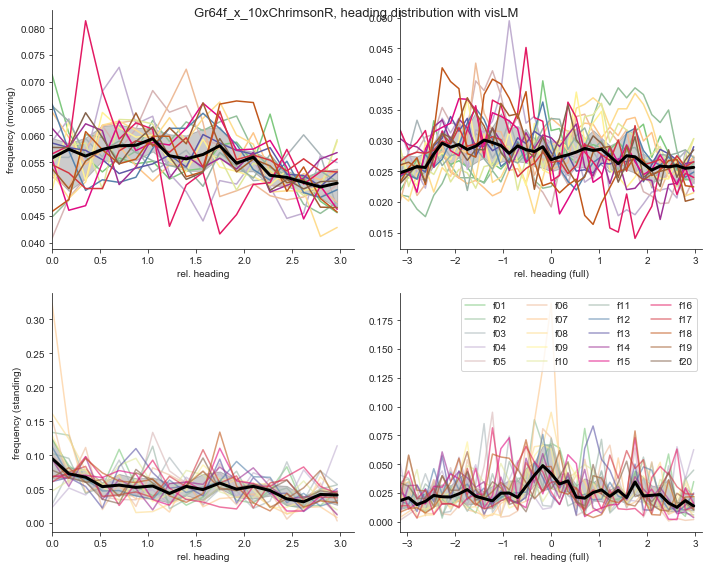

<Figure size 720x576 with 0 Axes>

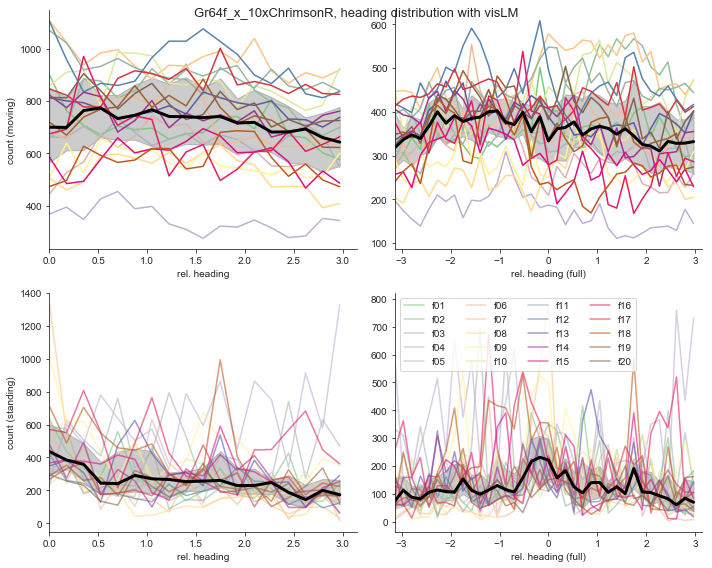

In [236]:
densityFlag = True
headingfig = plt.figure(figsize=(10,8))
titleString = genotype+', heading distribution with '+ protocol
mindistdf = FOAllFlies_df.query('LMdist > '+str(minLMdist))
headingfig, nhead_fullGamma = plotHeadingComparison(mindistdf, flyIDs, protocol,minLMdist,
                                                    titleString, flyCMap, densityFlag, True)

headingCountfig = plt.figure(figsize=(10,8))
densityFlag = False
titleString = genotype+', heading distribution with '+ protocol

headingCountfig, nhead_fullGamma = plotHeadingComparison(mindistdf, flyIDs, protocol,minLMdist,
                                                    titleString, flyCMap, densityFlag, True)
headingfig.savefig(analysisDir + sep + 'heading' + sep + genotype +
                   '_headingDistribution_'+protocol+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')
headingCountfig.savefig(analysisDir + sep + 'heading' + sep + genotype
                        + '_headingCounts_'+protocol+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Circular statistics on heading distribution

In [237]:
headingPVA = np.nan*np.ones((numFlies,2))
anglePVA = np.nan*np.ones((numFlies,2))
fliesNotWalking = 0
    
for fly in range(numFlies):
    querystring = '(sceneName=="' + protocol + '") & (flyID =="' + flyIDs[fly] +  '")'
    scene_df = FOAllFlies_df.query(querystring)
    if len(scene_df) == 0: continue
    nTrial = len(scene_df['moving'].squeeze().astype('int').values)
    scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')

    moving = scene_df['moving'].squeeze().astype('int').values
    perFlyG = scene_df['gammaFull'].squeeze().astype('float').values
    perFlyA = scene_df['headingAngle'].squeeze().astype('float').values

    if sum(moving)<=0.2*nTrial:
        print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,nTrial)))
        fliesNotWalking += 1
        continue

    gamFul = perFlyG[moving>0]
    meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

    headingPVA[fly,0] = meandir
    headingPVA[fly,1] = meanlen

    angle = perFlyA[moving>0]
    meandir, meanlen = circmeanvec(angle[~np.isnan(angle)],np.ones(len(angle[~np.isnan(angle)])), high=angleHigh, low=angleLow)

    anglePVA[fly,0] = meandir
    anglePVA[fly,1] = meanlen

try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
        
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_dir_'+protocol+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_len_'+protocol+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_dir_'+protocol+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_len_'+protocol+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,1], delimiter=',')

Analysis directory already exists.


In [238]:
def polarHeadingPlot(titlestr,ax, r, theta, col, dotsize,alphaval, rmax):
    ax.plot(r,theta,'.',markersize=dotsize,color=col,alpha=alphaval)
    ax.set_theta_zero_location('N')
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_rlim(0,rmax)
    ax.set_rlabel_position(225)
    ax.set_title(titlestr)

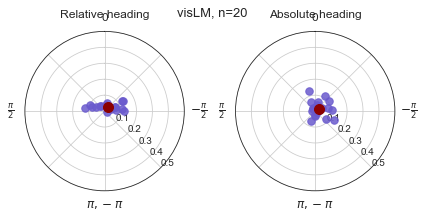

In [239]:
relvsabsfig = plt.figure(figsize=(6,3))

rmax = 0.5
ax = relvsabsfig.add_subplot(1,2,1,projection='polar')
polarHeadingPlot('Relative heading',ax, headingPVA[:,0],headingPVA[:,1],condCol[0],15,0.85,rmax)
meandir, meanlen = circmeanvec(headingPVA[~np.isnan(headingPVA[:,0]),0], headingPVA[~np.isnan(headingPVA[:,1]),1],
                               high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)

ax = relvsabsfig.add_subplot(1,2,2,projection='polar')
polarHeadingPlot('Absolute heading',ax, anglePVA[:,0],anglePVA[:,1],condCol[0],15,0.85,rmax)
meandir, meanlen = circmeanvec(anglePVA[~np.isnan(anglePVA[:,0]),0], anglePVA[~np.isnan(anglePVA[:,1]),1],
                               high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)


relvsabsfig.tight_layout()
relvsabsfig.suptitle(protocol + ', n='+str(numFlies),fontsize=13)
relvsabsfig.savefig(analysisDir + 'circStats/'  + genotype + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

## Fit von Mises distribution

In [240]:
def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

def vMbiModFunc(x, mu1, mu2, kappa):
    return ( (np.exp(kappa * np.cos(x-mu1)) / (2*np.pi*np.i0(kappa))) + (np.exp(kappa * np.cos(x-mu2)) / (2*np.pi*np.i0(kappa))) )/2

In [241]:
def plotOneTrialHeading(ax1, ax2, gammaful, time, meandir, meanlen):
    ax1.plot(time, gammaful)
    ax1.set_ylim(angleLow, angleHigh)
    ax1.set_xlim(0,600)
    myAxisTheme(ax1)
    
    ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
    ax2.set_rlim(0,0.8)
    ax2.set_rlabel_position(180)
    ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

### Fit unimodal von Mises

In [242]:
scene_df.head()

,flyID,trial,trialtype,reinforcement,sceneName,moving,gamma,gammaFull,LMdist,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f20,20.0,post,off,visLM,1.0,NaN,NaN,NaN,-0.000004,-0.760924,0.000000,4.952972,60.622000,NaN,35.000000,NaN,0.0
1,f20,20.0,post,off,visLM,1.0,NaN,NaN,NaN,-0.038053,5.652408,0.050003,9.754339,60.866555,NaN,34.960873,NaN,0.0
2,f20,20.0,post,off,visLM,1.0,NaN,NaN,NaN,0.244587,3.804455,0.100007,6.926789,61.016210,NaN,34.496649,NaN,0.0
3,f20,20.0,post,off,visLM,1.0,NaN,NaN,NaN,0.434823,0.434802,0.150010,11.512627,60.697600,NaN,34.360800,NaN,0.0
4,f20,20.0,post,off,visLM,1.0,NaN,NaN,NaN,0.456564,2.500050,0.200014,14.541825,61.273200,NaN,34.369800,NaN,0.0


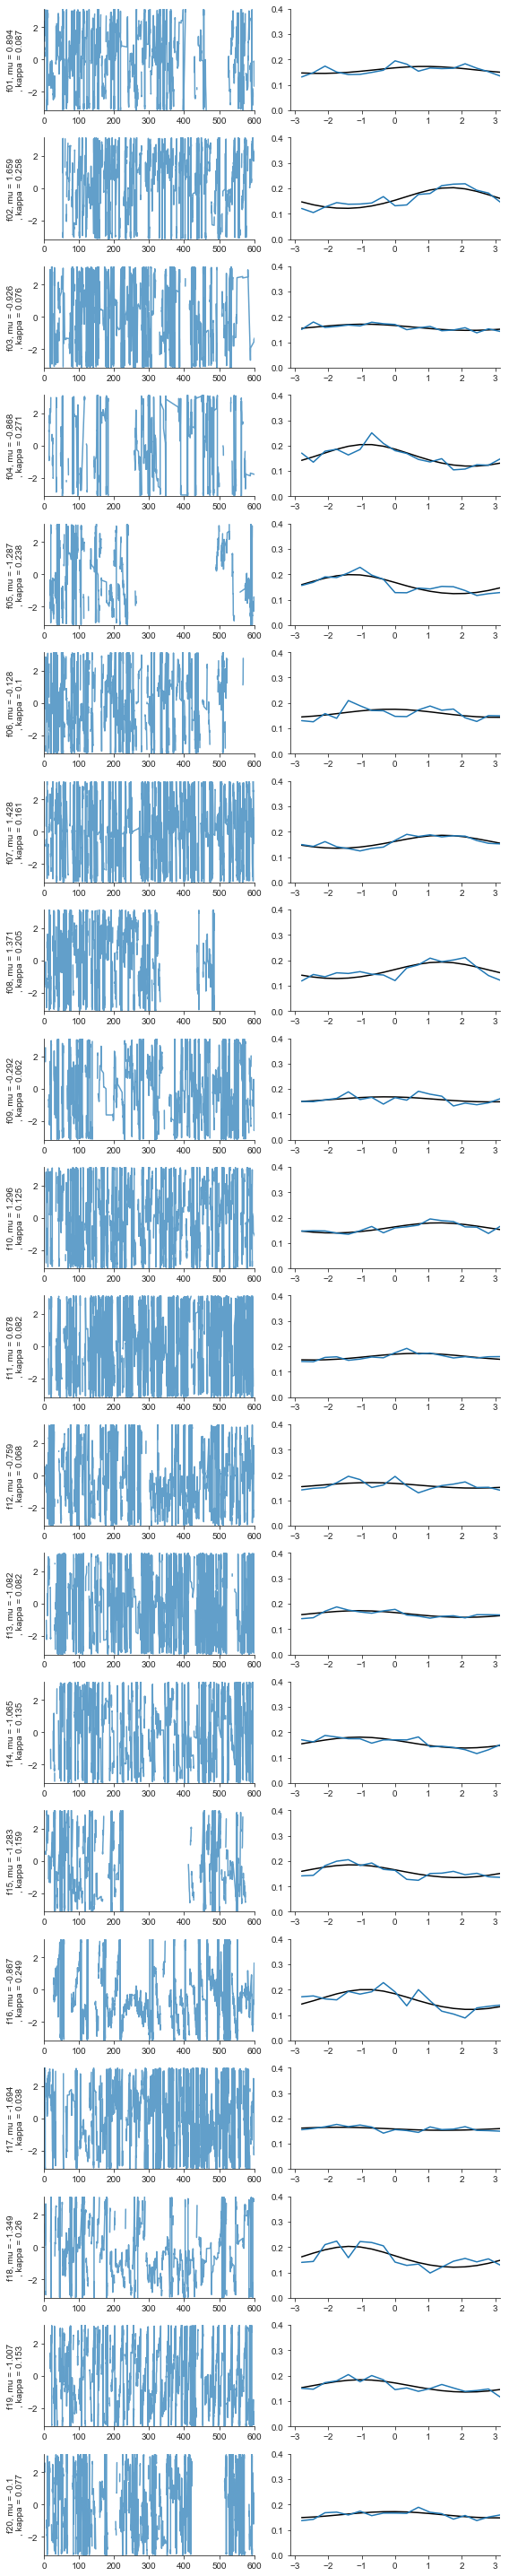

In [243]:
#bins size
binwidth = 20 #deg
numFlies = len(flyIDs)
vmfits = np.nan*np.ones((5,numFlies))

fitFig = plt.figure(figsize=(8,2*numFlies))

for fly in range(numFlies):
    querystring = '(sceneName=="' + protocol + '") & (flyID =="' + flyIDs[fly] +  '")'
    scene_df = FOAllFlies_df.query(querystring)
    if len(scene_df) == 0: continue
    nTrial = len(scene_df['moving'].squeeze().astype('int').values)
    
    scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')

    moving = scene_df['moving'].values.squeeze().astype('int')
    perFlyG = scene_df['gammaFull'].values.squeeze().astype('float')
    perFlyT = scene_df['time'].values.astype('float')

    if sum(moving)<=0.2*nTrial:
        print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,nTrial)))
        continue

    gamFul = perFlyG[moving>0]
    time = perFlyT[moving>0]

    bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(gamFul,bins=(360/binwidth), range=(angleLow,angleHigh), normed=True)
    meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

    popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
    mu = popt[0]
    kappa = popt[1]
    yhat = vMFunc(x,mu,kappa)

    #compute kolmogorov-smirnov statistic as measure of goodness of fit
    [ks, p] = sts.ks_2samp(n, yhat)

    #compute squared difference from fit
    sqd = np.sum(np.square(n-yhat))

    vmfits[0,fly] = mu
    vmfits[1,fly] = kappa
    vmfits[2,fly] = sqd
    vmfits[3,fly] = p
    vmfits[4,fly] = ks

    #plot fit results
    ax = fitFig.add_subplot(numFlies,2,1+fly*2)
    ax.plot(time, gamFul,alpha=0.7)
    ax.set_xlim(0,600)
    ax.set_ylim(angleLow,angleHigh)
    if(kappa>kappaTH):
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)),   fontweight = 'bold')
    else:
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))

    myAxisTheme(ax)

    ax = fitFig.add_subplot(numFlies,2,2+fly*2)
    ax.plot(x,yhat,'k')
    ax.plot(x,n)
    ax.set_ylim(0,0.4)
    ax.set_xlim(angleLow,angleHigh)
    myAxisTheme(ax)

fitFig.tight_layout()

fitFig.savefig(analysisDir+'circStats/'+ genotype+'_'+protocol+ '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

flies with heading distribution that is significantly different from von Mieses fit (KS test):
['f17']
flies with large summed squared error:
[]


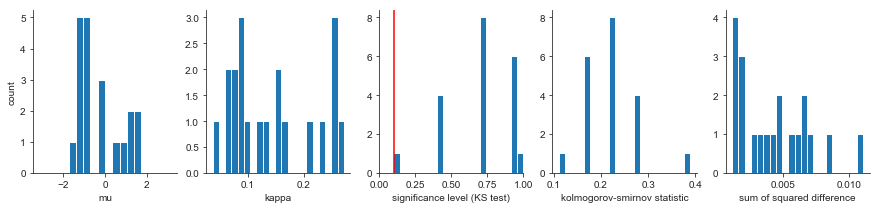

In [244]:
fitFig = plt.figure(figsize=(15,3))

bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

muax = fitFig.add_subplot(151)
muax.hist(vmfits[0,~np.isnan(vmfits[0,:])],bins)
muax.set_ylabel('count')
muax.set_xlabel('mu')
myAxisTheme(muax)

bins = np.linspace(0, 2, 21)
kapax = fitFig.add_subplot(152)
kapax.hist(vmfits[1,~np.isnan(vmfits[1,:])],len(bins))
kapax.set_xlabel('kappa')
myAxisTheme(kapax)

bins = np.linspace(0, 1, 21)
pax = fitFig.add_subplot(153)
pax.hist(vmfits[3,~np.isnan(vmfits[3,:])],len(bins))
pax.set_xlim(0, 1)
pax.axvline(0.1,color='red')
pax.set_xlabel('significance level (KS test)')

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(154)
ksax.hist(vmfits[4,~np.isnan(vmfits[4,:])],len(bins))
ksax.set_xlabel('kolmogorov-smirnov statistic')
myAxisTheme(ksax)

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(155)
ksax.hist(vmfits[2,~np.isnan(vmfits[2,:])],len(bins))
ksax.set_xlabel('sum of squared difference')
myAxisTheme(ksax)

print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
print([flyIDs[fly] for fly in np.where(vmfits[3,:]<=0.1)[0]])

print('flies with large summed squared error:')
print([flyIDs[fly] for fly in np.where(vmfits[2,:]>=0.08)[0]])

myAxisTheme(pax)

fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + protocol
               + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

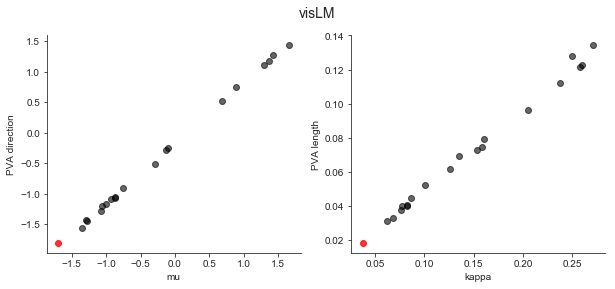

In [245]:
# Correlation between von Mieses fit and PVA
#Plot fit results
corrFig = plt.figure(figsize=(10,4))
corrFig.suptitle(protocol,fontsize=14)

notFit = np.logical_and(np.logical_and(vmfits[3,:]<=0.1, headingPVA[:,1]<0.5),\
                        ~np.isnan(headingPVA[:,1]))

#correlation between mu and PVA direction
muax = corrFig.add_subplot(121)
muax.plot(vmfits[0,~notFit],headingPVA[~notFit,0],'ko',alpha=0.6)
muax.plot(vmfits[0,notFit],headingPVA[notFit,0],'ro',alpha=0.8)
muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
myAxisTheme(muax)

#correlation between kappa and PVA length
kapax = corrFig.add_subplot(122)
kapax.plot(vmfits[1,~notFit],headingPVA[~notFit,1],'ko',alpha=0.6)
kapax.plot(vmfits[1,notFit],headingPVA[notFit,1],'ro',alpha=0.8)
kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
myAxisTheme(kapax)

corrFig.savefig(analysisDir+'circStats/'+genotype+'_'+protocol+ '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

problem with sample
nan
problem with sample
nan


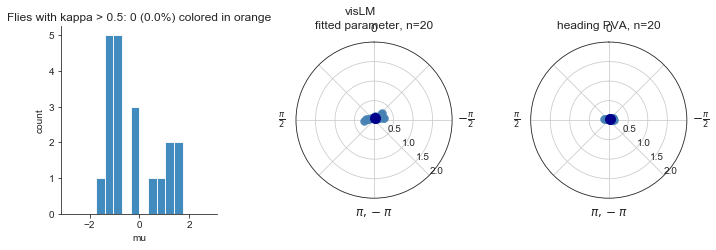

In [246]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),~np.isnan(headingPVA[:,1]))
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)
bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(vmfits[0,~np.isnan(vmfits[0,:])],bins)
[n_slct,edg] = np.histogram(vmfits[0,slct],bins)

#Plot fit results
fixFig = plt.figure(figsize=(10,3.5))
fixFig.suptitle(protocol,fontsize=12)

#histogram of fitted location (mu)
muax = fixFig.add_subplot(131)
muax.hist(vmfits[0,~np.isnan(vmfits[0,:])],bins,alpha=0.85)
muax.hist(vmfits[0,slct],bins,color='tomato',alpha=0.85)
muax.set_xlim(-np.pi, np.pi)
muax.set_xlabel('mu')
muax.set_ylabel('count')
muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[1,:]>kappaTH))+' ('+\
               str(round(100.0*sum(vmfits[1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
myAxisTheme(muax)

#polar plot of fitted location and shape parameter
ax = fixFig.add_subplot(132,projection='polar')
polarHeadingPlot('fitted parameter, n='+str(numFlies),ax, vmfits[0,:],vmfits[1,:],'grey',10,0.85,rmax)
ax.plot(vmfits[0,goodFit],vmfits[1,goodFit],'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,goodFit],vmfits[1,goodFit], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
ax.plot(vmfits[0,slct],vmfits[1,slct],'.',markersize=11,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,slct],vmfits[1,slct], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
ax.set_rlim(0,2)

#polar plot of PVA
ax = fixFig.add_subplot(133,projection='polar')
polarHeadingPlot('heading PVA, n='+str(numFlies),ax,headingPVA[:,0],headingPVA[:,1],'grey',10,0.85, rmax)
ax.plot(headingPVA[goodFit,0],headingPVA[goodFit,1],'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
ax.plot(headingPVA[slct,0],headingPVA[slct,1],'.',markersize=11,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[slct,0],headingPVA[slct,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
ax.set_rlim(0,2)

fixFig.tight_layout()
fixFig.savefig(analysisDir+'circStats/'+genotype+'_'+protocol+'_vMFixation_n'+str(numFlies)+'.pdf', format='pdf') 

### Fit bimodal von Mises to those distributions for which no good unimodal fit was found

f17


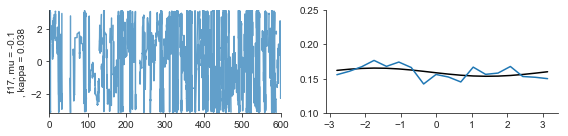

In [247]:
#bins size
binwidth = 20 #deg
numFlies = len(flyIDs)
vmbmfits = np.nan*np.ones((6,numFlies))
    
noFit = np.logical_and(np.logical_and(vmfits[3,:]<=0.1, headingPVA[:,1]<0.5),~np.isnan(headingPVA[:,1]))

notGoodFit = np.where(noFit>0)[0]
if(len(notGoodFit)!=0):
    fitFig = plt.figure(figsize=(8,2*len(notGoodFit)))

    for ind, fly in enumerate(notGoodFit):
        print(flyIDs[fly])
        querystring = '(sceneName=="' + protocol + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')

        moving = scene_df['moving'].values.squeeze().astype('int')
        perFlyG = scene_df['gammaFull'].values.squeeze().astype('float')
        perFlyT = scene_df['time'].values.astype('float')

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]

        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins = 360/binwidth, range=(angleLow,angleHigh), normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        mu01 = np.nanmax(n)
        mu02 = np.mod(mu01+2*np.pi,2*np.pi)-np.pi

        popt, pcov = curve_fit(vMbiModFunc, x, n, p0=[mu01,mu02,meanlen_freq],\
                               bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
        mu1 = popt[0]
        mu2 = popt[1]
        kappa = popt[2]
        yhat = vMbiModFunc(x,mu1,mu2,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmbmfits[0,fly] = mu1
        vmbmfits[1,fly] = mu2
        vmbmfits[2,fly] = kappa
        vmbmfits[3,fly] = sqd
        vmbmfits[4,fly] = p
        vmbmfits[5,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(len(notGoodFit),2,1+ind*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(len(notGoodFit),2,2+ind*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylim(0.1,0.25)
        myAxisTheme(ax)

        fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + protocol
                   + '_vMbiModFit_n'+ str(numFlies) +'.pdf', format='pdf') 

flies with heading distribution that is significantly different from von Mieses fit (KS test):
['f17']


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less_equal


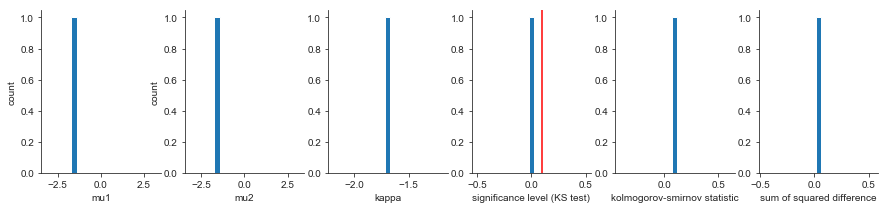

In [248]:
fitFig = plt.figure(figsize=(15,3))

bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

muax = fitFig.add_subplot(161)
muax.hist(vmbmfits[0,~np.isnan(vmbmfits[0,:])],bins)
muax.set_ylabel('count')
muax.set_xlabel('mu1')
myAxisTheme(muax)

muax = fitFig.add_subplot(162)
muax.hist(vmbmfits[0,~np.isnan(vmbmfits[1,:])],bins)
muax.set_ylabel('count')
muax.set_xlabel('mu2')
myAxisTheme(muax)

bins = np.linspace(0, 2, 21)
kapax = fitFig.add_subplot(163)
kapax.hist(vmbmfits[1,~np.isnan(vmbmfits[2,:])],len(bins))
kapax.set_xlabel('kappa')
myAxisTheme(kapax)

bins = np.linspace(0, 1, 21)
pax = fitFig.add_subplot(164)
pax.hist(vmbmfits[3,~np.isnan(vmbmfits[4,:])],len(bins))
#pax.set_xlim(0, 1)
pax.axvline(0.1,color='red')
pax.set_xlabel('significance level (KS test)')

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(165)
ksax.hist(vmbmfits[4,~np.isnan(vmbmfits[5,:])],len(bins))
#ksax.set_xlim(0, 1)
ksax.set_xlabel('kolmogorov-smirnov statistic')
myAxisTheme(ksax)

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(166)
ksax.hist(vmbmfits[2,~np.isnan(vmbmfits[3,:])],len(bins))
#ksax.set_xlim(0, 1)
ksax.set_xlabel('sum of squared difference')
myAxisTheme(ksax)

print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
print([flyIDs[fly] for fly in np.where(vmbmfits[4,:]<=0.1)[0]])

myAxisTheme(pax)

fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + protocol
               + '_vMbiModFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


problem with sample
nan
problem with sample
nan


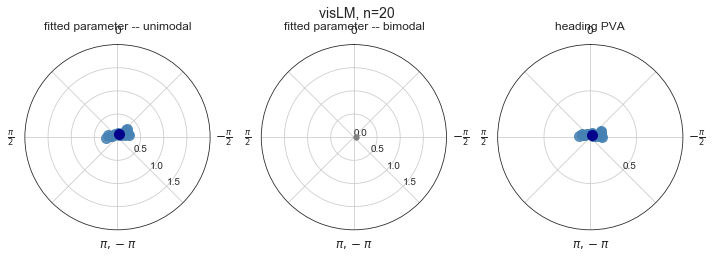

In [249]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

rlim = 2
    
goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),~np.isnan(headingPVA[:,1]))
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

goodFit_bm = vmbmfits[4,:]>0.1
slct_bm = np.logical_and(vmbmfits[2,:]>kappaTH,goodFit_bm)

#Plot fit results
fixFig = plt.figure(figsize=(10,3.75))
fixFig.suptitle(protocol+', n='+str(numFlies),fontsize=14)

#polar plot of fitted location and shape parameter - unimodal
ax = fixFig.add_subplot(131,projection='polar')
polarHeadingPlot('fitted parameter -- unimodal',ax, vmfits[0,:],vmfits[1,:],'grey',10,0.85,rmax)
ax.plot(vmfits[0,goodFit],vmfits[1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,goodFit],vmfits[1,goodFit], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
ax.plot(vmfits[0,slct],vmfits[1,slct],'.',markersize=12,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,slct],vmfits[1,slct], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
ax.set_rlim(0,rlim)
ax.set_yticks(np.linspace(0,rlim, 2*rlim, endpoint=False))

#polar plot of fitted location and shape parameter - bimodal
ax = fixFig.add_subplot(132,projection='polar')
polarHeadingPlot('fitted parameter -- bimodal',ax, vmbmfits[0,:],vmbmfits[2,:],'grey',10,0.85,rmax)
ax.plot(vmbmfits[1,:],vmbmfits[2,:],'.',markersize=10,color='grey',alpha=0.85)
ax.plot([vmbmfits[0,:],vmbmfits[1,:]],[vmbmfits[2,:],vmbmfits[2,:]],'-',color='grey',alpha=0.8)
ax.plot(vmbmfits[0,goodFit_bm],vmbmfits[2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
ax.plot(vmbmfits[1,goodFit_bm],vmbmfits[2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
ax.plot(vmbmfits[0,slct_bm],vmbmfits[2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
ax.plot(vmbmfits[1,slct_bm],vmbmfits[2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
ax.set_rlim(0,rlim)
ax.set_yticks(np.linspace(0,rlim, 2*rlim, endpoint=False))

#polar plot of PVA
ax = fixFig.add_subplot(133,projection='polar')
polarHeadingPlot('heading PVA',ax, headingPVA[:,0],headingPVA[:,1],'grey',10,0.85,rmax)
ax.plot(headingPVA[goodFit,0],headingPVA[goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
ax.plot(headingPVA[slct,0],headingPVA[slct,1],'.',markersize=12,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[slct,0],headingPVA[slct,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
ax.set_rlim(0,1)
ax.set_yticks(np.linspace(0,1,2, endpoint=False))

fixFig.tight_layout()
fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + protocol
               + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

np.savetxt(analysisDir + 'circStats/'  + genotype + '_vMFixation_'+protocol+'_n'+ str(numFlies) +'.csv',
           np.c_[vmfits[0,:],vmfits[1,:],goodFit,vmbmfits[0,:],vmbmfits[1,:],vmbmfits[2,:],goodFit_bm],
           delimiter=',', header='mu,kappa,gof,mu1_bm,mu2_bm,kappa_bm,gof_bm')
    

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


problem with sample
nan


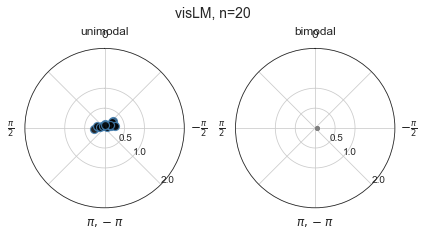

In [250]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)
sceneYLim = 2
goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),~np.isnan(headingPVA[:,1]))
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)
gfplt = np.logical_and(goodFit, ~slct)

goodFit_bm = vmbmfits[4,:]>0.1
slct_bm = np.logical_and(vmbmfits[2,:]>kappaTH,goodFit_bm)
gfplt_bm = np.logical_and(goodFit_bm, ~slct_bm)

#Plot fit results
fixFig = plt.figure(figsize=(6,3.5))
fixFig.suptitle(protocol+', n='+str(numFlies),fontsize=14)

#polar plot of fitted location and shape parameter - unimodal
ax = fixFig.add_subplot(121,projection='polar')
polarHeadingPlot('unimodal',ax,vmfits[0,~goodFit],vmfits[1,~goodFit],'grey',8,0.85,rmax)
ax.plot(vmfits[0,gfplt],vmfits[1,gfplt],'o',markeredgecolor='steelblue',markerfacecolor='none',  markeredgewidth=1.2, markersize = 8,alpha=0.85)
ax.plot(vmfits[0,slct],vmfits[1,slct],'o',markersize=9,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,slct],vmfits[1,slct], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'x', color='darkred',alpha=1, markersize=9)
ax.set_yticks([0.5, 1, 2, 3])
ax.set_ylim(0, sceneYLim)

#polar plot of fitted location and shape parameter - bimodal
ax = fixFig.add_subplot(122,projection='polar')
polarHeadingPlot('bimodal',ax,vmbmfits[0,~goodFit_bm],vmbmfits[2,~goodFit_bm],'grey',8,0.85,rmax)
ax.plot(vmbmfits[1,~goodFit_bm],vmbmfits[2,~goodFit_bm],'.',markersize=8,color='grey',alpha=0.85)
ax.plot([vmbmfits[0,goodFit_bm],vmbmfits[1,goodFit_bm]],[vmbmfits[2,goodFit_bm],vmbmfits[2,goodFit_bm]],'-',color='grey',alpha=0.8)
ax.plot(vmbmfits[0,gfplt_bm],vmbmfits[2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', markeredgewidth=1.2, markersize = 8,alpha=0.85)
ax.plot(vmbmfits[1,gfplt_bm],vmbmfits[2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', markeredgewidth=1.2, markersize = 8,alpha=0.85)
ax.plot(vmbmfits[0,slct_bm],vmbmfits[2,slct_bm],'o',markersize=9,color='steelblue',alpha=0.85)
ax.plot(vmbmfits[1,slct_bm],vmbmfits[2,slct_bm],'o',markersize=9,color='steelblue',alpha=0.85)
ax.set_yticks([0.5, 1, 2, 3])
ax.set_ylim(0, sceneYLim)

fixFig.tight_layout()
fixFig.savefig(analysisDir+'circStats/'+genotype+'_'+protocol+'_vMBiModFixation_n'+str(numFlies)+'.pdf', format='pdf') 

### Selection of data

In [251]:
print('Total number of flies measured: ' + str(numFlies))
goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5), ~np.isnan(headingPVA[:,1]))
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

goodFit_bm = vmbmfits[4,:]>0.1

slct_bm = np.logical_and(vmbmfits[2,:]>kappaTH,goodFit_bm)

print('Number of flies that walked for less than 20% of trial time: {} ({})'.format(int(fliesNotWalking),numFlies))

print('Unimodal fits:')
print('  Number of walking flies for which von Mises was good fit: {} ({})'.format(sum(goodFit),
                                                                                   numFlies-int(fliesNotWalking)))
print('  Total number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
      +str(sum(vmfits[1,:]>kappaTH)) + ' ('+str(numFlies-int(fliesNotWalking))+')')
print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
      +str(sum(vmfits[1,goodFit]>kappaTH)) + ' ('+str(sum(goodFit))+')')

print('Bimodal fits:')
print('  Number of walking flies for which bimodal von Mises was good fit: ' + str(sum(goodFit_bm))\
      + ' ('+str(sum(~goodFit)-int(fliesNotWalking))+')')
print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
      +str(sum(vmbmfits[2,goodFit_bm]>kappaTH)) + ' ('+str(sum(goodFit_bm))+')')

Total number of flies measured: 20
Number of flies that walked for less than 20% of trial time: 0 (20)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 19 (20)
  Total number of fitted distributions with concentration measure kappa > 0.5: 0 (20)
  Number of well fitted distributions with concentration measure kappa > 0.5: 0 (19)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 0 (1)
  Number of well fitted distributions with concentration measure kappa > 0.5: 0 (0)


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


### Use Rayleigh test on mean fixation location (on selected data, conditioned on good fit with unimodal von Mises)

In [252]:
# ...based on on fitted location parameter mu 
goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),\
                          ~np.isnan(headingPVA[:,1]))

slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

fitSamples = len(vmfits[0,slct])

PVAdir, PVAlen = circmeanvec(vmfits[0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,fitSamples)

print('Test statistic z = ' + str(z))
print('Probability of test statistic p = ' + str(p))
if (p<0.001):
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.01): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.05): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
else:
    print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')

problem with sample
nan
Test statistic z = nan
Probability of test statistic p = nan
Accept H0 that sample is drawn from a uniform distribution (p>0.01).


### Visualise performance with bar plot

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


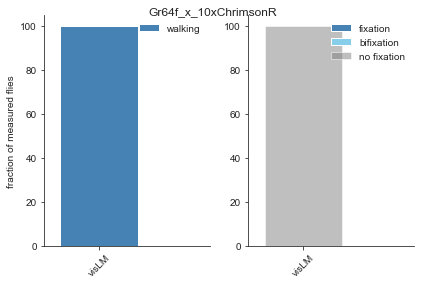

In [253]:
fixBarFig, ax  = plt.subplots(1, 2, figsize=(6,4))
width = 0.7

walking = 100.0*(numFlies - int(fliesNotWalking))/numFlies

goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),~np.isnan(headingPVA[:,1]))
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

goodFit_bm = vmbmfits[4,:]>0.1
slct_bm = np.logical_and(vmbmfits[2,:]>kappaTH,goodFit_bm)

fixating = 100.0*sum(vmfits[1,goodFit]>kappaTH)/(numFlies - int(fliesNotWalking))
bifixating = 100.0*sum(vmbmfits[2,goodFit_bm]>kappaTH)/(numFlies - int(fliesNotWalking))

p11 = ax[0].bar(0, walking, width, color='steelblue', alpha=1)

p21 = ax[1].bar(0, fixating, width, color='steelblue')
p22 = ax[1].bar(0, bifixating, width, bottom=fixating, color='skyblue')
p23 = ax[1].bar(0, 100.0-(fixating+bifixating), width, bottom=(fixating+bifixating),color='grey', alpha=0.5)

ax[0].legend([p11], ['walking'],frameon=False)
ax[0].set_ylabel('fraction of measured flies')
ax[0].set_xlim(-0.5, len([protocol]))
plt.sca(ax[0])
plt.xticks(range(len([protocol])), [protocol], rotation=45)
myAxisTheme(ax[0])

ax[1].legend([p21, p22, p23], ['fixation','bifixation', 'no fixation'],frameon=False)
ax[1].set_xlim(-0.5, len([protocol]))
plt.sca(ax[1])
plt.xticks(range(len([protocol])), [protocol], rotation=45)
myAxisTheme(ax[1])

fixBarFig.suptitle(genotype)
fixBarFig.tight_layout()

fixBarFig.savefig(analysisDir + 'circStats/' + genotype+'_'+protocol +'_fixationBarPlot_n'+ str(numFlies) +'.pdf', format='pdf') 

### Walking velocity ~ fixation

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


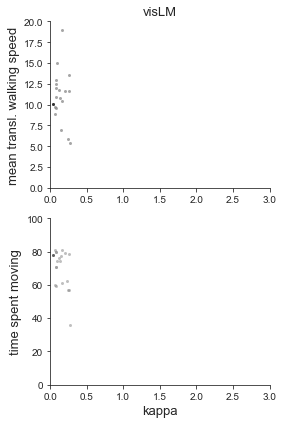

In [254]:
walkingCorr, axs = plt.subplots(2, 1, figsize=(4,6))
    
goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),~np.isnan(headingPVA[:,1]))
goodFit_bm = vmbmfits[4,:]>0.1

kappasFly = [vmfits[1,:], vmbmfits[2,:]]
slct = [np.logical_and(vmfits[1,:]>kappaTH,goodFit),np.logical_and(vmbmfits[2,:]>kappaTH,goodFit_bm)]
markerstyle = [('grey', 'o'), ('black','^')]

for fly in range(numFlies):
    querystring = '(flyID == "' + flyIDs[fly] + '" & sceneName == "'+protocol+'")'
    scene_df = FOAllFlies_df.query(querystring)
    if len(scene_df)==0 : continue
    scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')

    flyMov = scene_df['moving'].values.squeeze().astype('int')
    flyVT = scene_df['transVelo'].values.astype('float')

    for i in range(2):
        if(len(kappasFly[i])==0): continue
        if(len(flyMov)==0): continue
        if slct[i][fly]:
            axs[0].plot(kappasFly[i][fly], np.nanmean(flyVT[flyMov>0]), markerstyle[i][1], color=flyCMap.to_rgba(fly))
        else:
            axs[0].plot(kappasFly[i][fly], np.nanmean(flyVT[flyMov>0]), '.',
                               markerfacecolor=markerstyle[i][0], markeredgecolor='none', alpha=.7)
        if slct[i][fly]:
            axs[1].plot(kappasFly[i][fly], 100.*np.sum(flyMov)/len(flyMov), markerstyle[i][1], color=flyCMap.to_rgba(fly))
        else:
            axs[1].plot(kappasFly[i][fly], 100.*np.sum(flyMov)/len(flyMov), '.', 
                               markerfacecolor=markerstyle[i][0], markeredgecolor='none', alpha=.5) 

axs[0].set_ylabel('mean transl. walking speed', fontsize=13)
axs[1].set_xlabel('kappa', fontsize=13)
axs[1].set_ylabel('time spent moving', fontsize=13)
axs[0].set_xlim(0, 3)
axs[0].set_ylim(0, 20)
axs[1].set_xlim(0, 3)
axs[1].set_ylim(0, 100)
axs[0].set_title(protocol, fontsize=13)
[myAxisTheme(axs[i]) for i in range(2)]

walkingCorr.tight_layout()
walkingCorr.savefig(analysisDir + 'velocityTraces'+sep+genotype+'_'+protocol+'_walkingCorr_n'+ str(numFlies)+'.pdf') 

## Intergroup comparison
uses saved data in csv file

In [264]:
analysisDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/Gr64f_x_10xChrimsonR_f/'
rootDir = analysisDir+ '/12cmHex/24h/'

kappaTH = 0.5

def stylePolarPlot(titlestr,ax,sceneYLim,ytickvals,scene):
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_title(titlestr)
    ax.set_rlabel_position(135)
    ax.set_xlim(0, 2*np.pi)
    ax.set_yticks(ytickvals)
    ax.set_ylim(0, sceneYLim[scene])
    ax.axvline(np.pi*(360-120)/360, 0,1, color='dimgrey', linewidth=0.5)
    ax.axvline(-np.pi*(360-120)/360, 0,1, color='dimgrey', linewidth=0.5)
    ax.set_theta_zero_location("N")
    ax.spines['polar'].set_visible(False)

### By genotype analysis

In [265]:
groupNames = ['noLM','visLM','onlyLM']  
temp = ['highT','highT','highT']
wings = ['cut','cut','cut']
genotypes =['Gr64f>Chr','Gr64f>Chr','Gr64f>Chr']
genotype = 'Gr64f_x_10xChrimsonR'
ns = [20,20,20]
sexs = ['female']

sceneNames = ['1cm4cmInvisibleCone + opt', '1cm4cmCone + opt', '1cm4cmCone']
sceneDim = ['2D', '2D', '2D']
contrast = ['darkOnBright', 'darkOnBright','darkOnBright']

# For genotype comparison: DL, WTB, WTB hybrid (all hightT, cut) -- male/female
groupCol = [['tomato','lightseagreen','darkorchid'],
            ['indianred','limegreen','dodgerblue']]

In [269]:
genotypes_df = pd.DataFrame()
keylist_gendf = ['genotype', 'group','wings','temp','sex','scene','contrast','sceneName',
               'trialType','flyID','# mu','kappa','gof','mu1_bm','mu2_bm','kappa_bm','gof_bm'] 

for i, group in enumerate(groupNames):
    path2data = rootDir +'/analysis/circStats/'
    subset_df = pd.read_csv(path2data + '{}_vMFixation_{}_n{}.csv'.format(genotype,group,ns[i]))

    subset_df.insert(0, 'genotype', genotypes[i])
    subset_df.insert(1, 'group', '{}-{}'.format(temp[i],wings[i]))
    subset_df.insert(2, 'wings', wings[i])
    subset_df.insert(3, 'temp', temp[i])
    subset_df.insert(4, 'sex', sexs[0])
    subset_df.insert(5, 'scene', sceneDim[i])
    subset_df.insert(6, 'contrast', contrast[i])
    subset_df.insert(7, 'sceneName', sceneNames[i])
    subset_df.insert(8, 'trialType', trialtype)
    subset_df.insert(9, 'flyID', range(len(subset_df)))

    genotypes_df = genotypes_df.append(subset_df)

genotypes_df["genotype"] = genotypes_df["genotype"].astype('category')
genotypes_df["wings"] = genotypes_df["wings"].astype('category')
genotypes_df["temp"] = genotypes_df["temp"].astype('category')
genotypes_df["sex"] = genotypes_df["sex"].astype('category')
genotypes_df["scene"] = genotypes_df["scene"].astype('category')
genotypes_df["contrast"] = genotypes_df["contrast"].astype('category')
genotypes_df["sceneName"] = genotypes_df["sceneName"].astype('category')
genotypes_df["group"] = genotypes_df["group"].astype('category')

In [275]:
analysisDir

'/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/Gr64f_x_10xChrimsonR_f/'

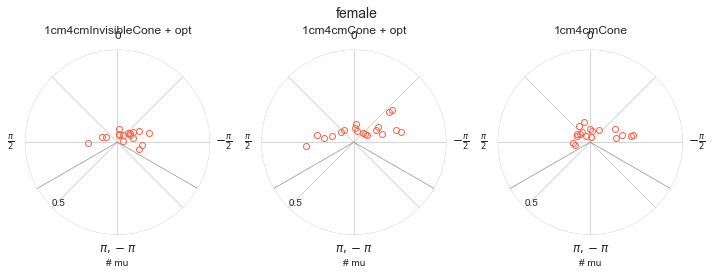

In [277]:
sceneYLim = [0.5,.5,.5]
ytickvals = [0.5, 1, 2, 3, 4]
for si, sex in enumerate(sexs):
    fixFig = plt.figure(figsize=(10,4))
    fixFig.suptitle(sex,fontsize=14)
    for scene, sceneName in enumerate(sceneNames):
        ax = fixFig.add_subplot(1,len(sceneNames),scene+1, projection='polar')
        
        for groupid, group in enumerate(genotypes_df.genotype.cat.categories.tolist()):
            currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & genotype=="{}"'.format(sceneName,sex,group))
            #notgof_df = currdf.query('gof == 0 & kappa >=0')
            #if not notgof_df.empty:
            #    notgof_df.plot(ax=ax, x="# mu", y="kappa",color='grey', marker='.',alpha=0.6, linestyle='none', grid=True, label='')
            
            gof_df = currdf.query('gof == 1 & kappa < '+str(kappaTH))
            if not gof_df.empty:
                gof_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',markerfacecolor='none',
                             markeredgewidth=1, markersize=6,linestyle='none',grid=True, label='')
            
            fix_df = currdf.query('gof == 1 & kappa >= '+str(kappaTH))
            if not fix_df.empty:
                if scene== 0:
                    fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',
                                markersize=8, alpha=0.8, linestyle='none', grid=True, label=group)
                else:
                    fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',
                                markersize=8, alpha=0.8, linestyle='none', grid=True, label='')
                               
            stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,scene)
        ax.legend(loc=2, frameon=False)
        
    fixFig.tight_layout()
    fixFig.savefig(analysisDir+ '/allGenotypes_vMFixation_highT-cut_' + sex+ '_uniModalFixation.pdf', format='pdf') 

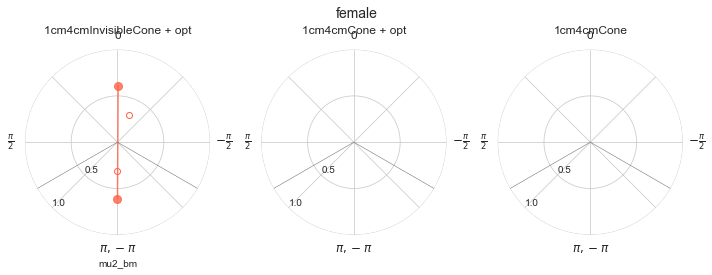

In [278]:
sceneYLim = [1,1,1]
ytickvals = [0.5, 1, 2, 3, 4]

for si, sex in enumerate(sexs):
    fixFig = plt.figure(figsize=(10,4))
    fixFig.suptitle(sex,fontsize=14)

    for sc, sceneName in enumerate(sceneNames):
        ax = fixFig.add_subplot(1,len(sceneNames),sc+1, projection='polar')

        for groupid, group in enumerate(genotypes_df.genotype.cat.categories.tolist()):
            currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & genotype=="{}"'.format(sceneName,sex,group))
            #notgof_df = currdf.query('gof_bm == 0 & kappa_bm >=0')
            #if not notgof_df.empty:
            #    notgof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color='grey', marker='.',alpha=0.6, linestyle='none', grid=True, label='')
            #    notgof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color='grey', marker='.',alpha=0.6, linestyle='none', grid=True, label='')
            
            gof_df = currdf.query('gof_bm == 1 & kappa_bm < '+str(kappaTH))
            if not gof_df.empty:
                gof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", markeredgecolor=groupCol[si][groupid], marker='o',
                        markerfacecolor='none',  markeredgewidth=1, markersize=6,linestyle='none',grid=True, label='')
                gof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", markeredgecolor=groupCol[si][groupid], marker='o',
                        markerfacecolor='none',  markeredgewidth=1, markersize=6,linestyle='none',grid=True, label='')
            
            fix_df = currdf.query('gof_bm == 1 & kappa_bm >= '+str(kappaTH))
            if not fix_df.empty:
                try:
                    x = [fix_df["mu1_bm"].values, fix_df["mu2_bm"].values]
                    y = [fix_df["kappa_bm"].values, fix_df["kappa_bm"].values]
                    ax.plot(x,y,alpha=0.8, color=groupCol[si][groupid], linewidth=1.5,label='')
                except KeyError:
                    print("KeyError " + group)
                    
                fix_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                            markersize=8, alpha=0.8, linestyle='none', grid=True,label='')
                if sc == 1:
                    fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                                markersize=8, alpha=0.8, linestyle='none', grid=True,label=group)
                else:
                    fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                                markersize=8, alpha=0.8, linestyle='none', grid=True,label='')

        stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,sc)
        ax.legend(loc=2, frameon=False)
        
    fixFig.tight_layout()
    fixFig.savefig(analysisDir+ '/allGenotypes_vMFixation_highT-cut_' + sex + '_biModalFixation.pdf', format='pdf') 

In [ ]:
for fly in range(numFlies):
    querystring = '(sceneName=="' + protocol + '") & (flyID =="' + flyIDs[fly] +  '")'
    scene_df = FOAllFlies_df.query(querystring)
    fig, axs = plt.subplots(1,1,figsize=(3,3))
    axs.scatter(scene_df['xPosInMiniarena'].values,scene_df['yPosInMiniarena'].values,scene_df['LMdist'].values,scene_df['LMdist'].values)
    myAxisTheme(axs)